<a href="https://colab.research.google.com/github/adamstra/Computer_Vision/blob/main/Devoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split

In [20]:
def load_mat_files(folder, variable_name):
    data_list = []
    for filename in os.listdir(folder):
        if filename.endswith(".mat"):
            mat_file = sio.loadmat(os.path.join(folder, filename))
            data_list.append(mat_file[variable_name])
    return np.array(data_list)


# Charger les données d'entrée et les ground truths
input_folder = "/content/drive/MyDrive/Computer_Vision/enroule"
gt_folder = "/content/drive/MyDrive/Computer_Vision/deroule"

X_data = load_mat_files(input_folder, "input")
y_data = load_mat_files(gt_folder, "gt")

In [28]:
# Normalisation des données
X_data = X_data / np.max(X_data)
y_data = y_data / np.max(y_data)

# Vérification des formes
print(f"Forme des données input: {X_data.shape}")
print(f"Forme des données ground truth: {y_data.shape}")

Forme des données input: (2000, 128, 128)
Forme des données ground truth: (2000, 128, 128)


In [22]:
X_data = X_data[:y_data.shape[0]]

In [29]:
# Ajouter une dimension supplémentaire pour les canaux (1 pour les images en niveaux de gris)
X_data = np.expand_dims(X_data, axis=-1)
y_data = np.expand_dims(y_data, axis=-1)

# Ensuite, divisez les données comme avant
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Vérification des formes après ajout de la dimension des canaux
print(f"Forme des données d'entraînement après ajout des canaux: {X_train.shape}")
print(f"Forme des données de validation après ajout des canaux: {X_val.shape}")

Forme des données d'entraînement après ajout des canaux: (1400, 128, 128, 1)
Forme des données de validation après ajout des canaux: (600, 128, 128, 1)


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [31]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Contraction path
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Expansive path
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [32]:
# Définir le modèle
input_shape = X_train.shape[1:]

# Supposons que vos données sont des images de forme (hauteur, largeur, canaux)
model = unet_model(input_shape)

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Affichage du résumé du modèle
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1   

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Entraînement du modèle
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

# Sauvegarder le modèle entraîné
model.save("unet_model.h5")

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 458ms/step - accuracy: 5.9296e-05 - loss: 0.6725 - val_accuracy: 6.1035e-05 - val_loss: 0.6403
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 6.1035e-05 - loss: 0.6402 - val_accuracy: 6.1035e-05 - val_loss: 0.6378
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 6.1035e-05 - loss: 0.6397 - val_accuracy: 6.1035e-05 - val_loss: 0.6385
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 6.1035e-05 - loss: 0.6398 - val_accuracy: 6.1035e-05 - val_loss: 0.6380
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 6.1035e-05 - loss: 0.6387 - val_accuracy: 6.1035e-05 - val_loss: 0.6369
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 6.1035e-05 - loss: 0.6369 - val_accuracy: 6.1035e-05 - val_loss: 0.6371
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 6.1035e-05 - loss: 0.6381 - val_accuracy: 6.1035e-05 - val_loss: 0.6375
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s

In [34]:
# Évaluer le modèle
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Loss sur validation: {val_loss}")
print(f"Accuracy sur validation: {val_accuracy}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 896ms/step - accuracy: 6.1035e-05 - loss: 0.6397
Loss sur validation: 0.6369131803512573
Accuracy sur validation: 6.103515625e-05


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


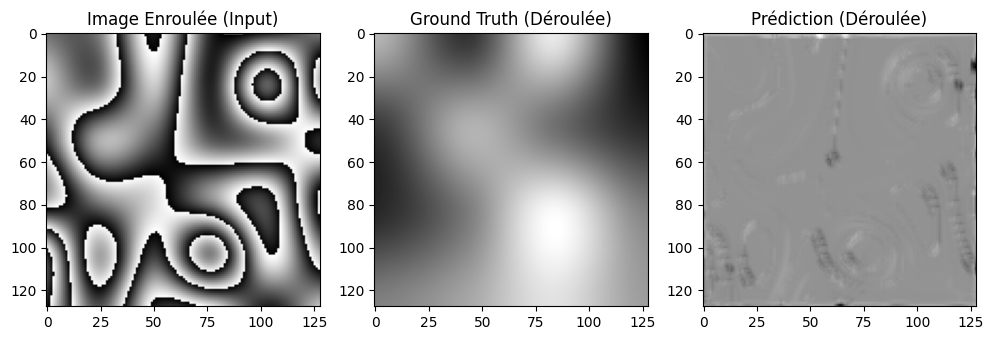

In [35]:
import matplotlib.pyplot as plt

# Faire des prédictions
y_pred = model.predict(X_val)

# Visualiser une image d'entrée, le ground truth et la prédiction
index = 0  # Changer l'indice pour visualiser d'autres images
plt.figure(figsize=(12, 4))

# Image d'entrée
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title('Image Enroulée (Input)')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(y_val[index].squeeze(), cmap='gray')
plt.title('Ground Truth (Déroulée)')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(y_pred[index].squeeze(), cmap='gray')
plt.title('Prédiction (Déroulée)')

plt.show()
